# Sprint 1: Genereren van dhydro_project met cases

In deze sprint definieren we de opzet van een DHYDRO project met meerdere cases. Een DHYDRO project bestaat uit de volgende componenten:
* `models`: een aantal DHYDRO modellen: het netwerk, de netwerk objecten (kunstwerken, profiel-locaties, etc) en de object-paramters (kruinhoogte, profieldefinities, etc, etc)
* `boundary_conditions`: dit zijn meerdere meteorologische randvoorwaarden in de sub-folder `meteo` en hydraulische randvoorwaarden in de sub-folder `flow`.
* `initial_conditions`: initiele condities voor de modellen, wederom gescheiden in de mapjes `rr` en `cf`.

Vanuit deze structuur volgt een aantal permutaties van modellen, randvoorwaarden en initiele condities die we, bijvoorbeeld, doorrekenen als onderdeel van een stochasten-onderzoek. Deze permutaties noemen we `cases` staan per case in een sub-map in de folder `cases` welke op gelijke hoogte staat met de bovengenoemde folders.

In een case-folder wordt <u>verwezen</u> naar een model, sets meteorologische en hydraulische randvoorwaarden en initiele condities. Ook bevat de case-folder de resultaten indien de case is doorgerekend.

## Aanmaken directory structuur

We maken de mappen-structuur aan voor ons D-HYDRO project:
- boundary_conditions:
    - flow: hydraulische randvoorwaarden (debiet en waterhoogte)
    - rr: neerslag-afvoer randvoorwaarden (neerslag + verdamping)
- cases: een directory met verwijzing naar boundary_conditions, intial_conditions en models
- initial_conditions: initiele condities voor het RR/CF model
- models: unieke RR/CF modellen

We maken een index-dictionary object aan, waarin we de structuur netjes bijhouden

In [1]:
from pathlib import Path
import shutil

# Our project_path
project_path = Path(r"../dhydro_project")
shutil.rmtree(project_path) #delete so we'll start with a fresh example

# Create boundary conditions
boundary_conditions_path = project_path / "boundary_conditions"
meteo_path = boundary_conditions_path / "meteo"
meteo_path.mkdir(parents=True, exist_ok=True)
flow_path = boundary_conditions_path / "flow"
flow_path.mkdir(parents=True, exist_ok=True)

# Create initial conditions
initial_conditions_path = project_path / "initial_conditions"
initial_conditions_path.mkdir(parents=True, exist_ok=True)

# Create model directory
models_path = project_path / "models"
models_path.mkdir(parents=True, exist_ok=True)

# Create cases directory
cases_path = project_path / "cases"
cases_path.mkdir(parents=True, exist_ok=True)

# Our index dict for administration
index = dict(cases=[],
             boundary_conditions=dict(flow=[],
                                      meteo=[]),
             initial_conditions=[],
             models=[])

## Aanmaken modellen
Voor nu kopieren we één model vanuit de data-folder naar de model-folder

In [2]:
import zipfile
zipped_base_model = Path("../data/e112_f01_c04_multiple_catchments.zip")

with zipfile.ZipFile(zipped_base_model) as zf:
    zf.extractall(models_path)
    
print("\n".join([str(i) for i in Path(models_path).glob("*")]))

index["models"].append(dict(id="e112_f01_c04_multiple_catchments",
                       name="testmodel aangeleverd door Deltares",
                       mdu_file="model4.mdu",
                       ext_file="model4.ext"))

..\dhydro_project\models\e112_f01_c04_multiple_catchments


## Kopieren hydraulische randvoorwaarden
Voor nu kopieren we de meegeleverde randvoorwaarde.

Later willen we randvoorwaarden genereren zoals bij het aanmaken van meteorologische forcering.

In [3]:
source_file = models_path.joinpath(r"e112_f01_c04_multiple_catchments/fm/model4.bc")
destination_file = flow_path / "default.bc"                               

shutil.copy(source_file, destination_file)

print("\n".join([str(i) for i in Path(flow_path).glob("*")]))

index["boundary_conditions"]["flow"].append(dict(id="default",
                                                 name="aangeleverd door Deltares"))

..\dhydro_project\boundary_conditions\flow\default.bc


## Initiele condities
Het default model maakt nog geen gebruik van initiele condities. In overleg met de TKI partners kunnen we een keuze maken welke soort CF-condities we gaan ondersteunen:
- polygonen met initiele waterstand
- XYZ locaties met initiele waterstand
- Initiele condities berekend uit een modelrun

## Aanmaken meteorologische randvooraarde

Meteorologische forcering schrijven we weg in het mapje `boundary_conditions_meteo`. De naam van elk forcering bestand volgt het patroon `{duur}H{volume}MM{patroon}`, waarbij:
- `duur`: de duur van de bui in uren
- `volume`: het totale volume van de bui in mm over de duur
- `patroon` het STOWA bui-patroon dat de bui moet volgen

Gegeven een bestandsnaam `NAAM` genereert de stowabui-module 3 bestanden:
`NAAM.BUI`: het bui-bestand
`NAAM.EVP`: het verdamping-bestand
`NAAM.TMP`: het temperatuur-bestand

Zie voor meer informatie de D-Hydro/Sobek gebruikershandleiding

### Meteorologische randvoorwaarden

De modulde `stowabui` is als onderdeel van deze TKI ontwikkeld voor het genereren van STOWA buien via Python. Deze module wordt hieronder geimporteerd. De MeteoEvent klasse binnen deze module maken we een standaard meteorologische forcing aan met een duur van 24 uur een bui-volume van 15mm het STOWA patroon `HOOG` en een verdamping van 0mm/dag. 

We maken hieronder de klasse aan en verifieren wat we hierboven beweren met een plotje. We printen ook de eigenschappen waarmee we een bui kunnen configureren:
- `meteo_event.duration`: de duur van de bui in een pd.Timedelta
- `meteo_event.volume.rainfall`: het volume van de neerslag over de duur
- `meteo_event.pattern`: het gebruikte buipatroon
- `meteo_event.season`: het gebruikte seizoen

duur: 1 days 00:00:00
volume: 15mm
patroon: HOOG
seizoen: zomer


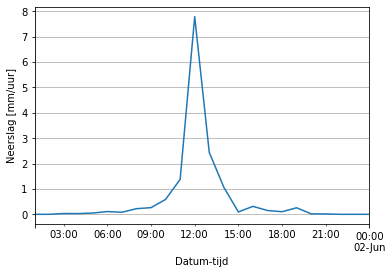

In [4]:
import stowabui
meteo_event = stowabui.MeteoEvent()
meteo_event.get_rainfall_series().plot(ylabel="Neerslag [mm/uur]", xlabel="Datum-tijd", grid=True)

print(f"""duur: {meteo_event.duration}
volume: {meteo_event.volume.rainfall}mm
patroon: {meteo_event.pattern}
seizoen: {meteo_event.season}""")

We gaan nu de aangemaakte meteo_event ook wegschrijven als bestanden. Dit doen we met de method `write_meteo`, waarbij we aangeven in welke map de bestanden moeten worden beschreven.

Na het wegschrijven bekijken we de inhoud van map. Zijn de bestanden correct geschreven?

In [5]:
meteo_event.write_meteo(meteo_path)

print("\n".join([str(i) for i in Path(meteo_path).glob("*.*")]))

..\dhydro_project\boundary_conditions\meteo\24H_15MM_HOOG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_HOOG_ZOMER.EVP
..\dhydro_project\boundary_conditions\meteo\24H_15MM_HOOG_ZOMER.TMP


We willen meer! We maken 24 buien aan waarbij we combineren:
- patroon `LAAG`, `MIDDELHOOG` en `HOOG`
- volumes `[15, 35, 50, 100]`
- seizoen `zomer` en `winter`

Na het wegschrijven bekijken we de inhoud van map. Zijn er inderdaad 24 bui-bestanden?

In [6]:
import itertools
patterns = ["LAAG", "MIDDELHOOG", "HOOG"]
volumes = [15, 35, 50, 100]
seasons = ["winter", "zomer"]

meteo_files = []

for i in itertools.product(*[patterns, volumes, seasons]):
    meteo_event.pattern = i[0]
    meteo_event.volume.rainfall = i[1]
    meteo_event.season = i[2]
    file_name = meteo_event.write_meteo(meteo_path)
    meteo_files.append({"id": file_name, "start":meteo_event.starts[i[2]]})
    index["boundary_conditions"]["meteo"].append(dict(id=file_name,
                                                 name=f"STOWA BUI: 24 uur, volume {i[1]} mm, patroon {i[0]}, seizoen {i[2]}"))
    
print("\n".join([str(i) for i in Path(meteo_path).glob("*.BUI")]))

..\dhydro_project\boundary_conditions\meteo\24H_100MM_HOOG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_100MM_HOOG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_100MM_LAAG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_100MM_LAAG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_100MM_MIDDELHOOG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_100MM_MIDDELHOOG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_HOOG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_HOOG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_LAAG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_LAAG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_MIDDELHOOG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_15MM_MIDDELHOOG_ZOMER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_35MM_HOOG_WINTER.BUI
..\dhydro_project\boundary_conditions\meteo\24H_35MM_HOOG_ZOMER.BUI
..\dhydro_p

## Aanmaken cases
Hier maken we voor alle runs een case-map aan. Elk mapje wordt voorzien van de volgende mappen en bestanden:
- FM met hierin fm_settings.mdu en de fm_boundaries.ext waarin verwezen wordt naar de juiste paden
- RR met hierin de rr_settings.fnm waarin verwezen wordt naar de juiste paden
- dimr_config.xml met de configuratie

<b>Let op (!); hier stopt de Notebook, omdat het lezen, wijzigen en schrijven van FM en RR config-bestanden nog niet lekker werkt in HYDROLIB-core</b>

In [7]:
from hydrolib.core.io.mdu.models import FMModel

cases = list(itertools.product(*[index["boundary_conditions"]["meteo"], 
                                 index["boundary_conditions"]["flow"],
                                 index["models"]]))

model_id = ""

for id, case in enumerate(cases):
    case_name = f"{'_'.join([i['id'] for i in case])}".upper()
    case_id = f"case_{id+1:04d}"
    case_path = cases_path / case_id
    case_path.mkdir(parents=True, exist_ok=True)
    
    if model_id != case[2]["id"]:
        print(model_id)
        model_id = case[2]["id"]
        mdu_file = models_path / model_id / "fm" / case[2]["mdu_file"]
        ext_file = models_path / model_id / "fm" / case[2]["ext_file"]
        fnm_file = models_path / model_id / "rr" / "sobek_3b.fnm"
        #fm_model = FMModel(filepath=mdu_file)
    
    #update index
    index["cases"].append(dict(id=case_id,
                              name=case_name,
                              mdu_file="fm_settings.mdu",
                              fnm_file="rr_settings.fnm",
                              model_id=model_id,
                              meteo_boundary_id=case[1]["id"],
                              intial_conditions_id=None,
                              flow_boundary_id=case[0]["id"],
                              results=False))

## Wegschrijven index

We schrijven de index weg als JSON, zodat we het overzicht van onze projectdirectory vastleggen.

In [8]:
import json
index_json = project_path / "index.json"

with open(index_json, "w+") as dst:
    dst.write(json.dumps(index, indent=4, sort_keys=False))